In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup          # BeautifulSoup is a useful library for extracting data from HTML and XML documents
from numpy import array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Dense, Embedding, LSTM, GRU
import pandas.testing as tm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import pandas as pd
file_path = '/content/drive/MyDrive/DSCproj/IMDB Dataset.csv'
movie_reviews = pd.read_csv(file_path)

# 5. Display the first 5 rows of the dataset
print(movie_reviews.head())


Mounted at /content/drive
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
# Check the shape of the data
movie_reviews.shape

(50000, 2)

In [ ]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Check for null Values
movie_reviews.isnull().sum()

,0
review,0
sentiment,0


In [ ]:
# Let us view one of the reviews
movie_reviews["review"][5]

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

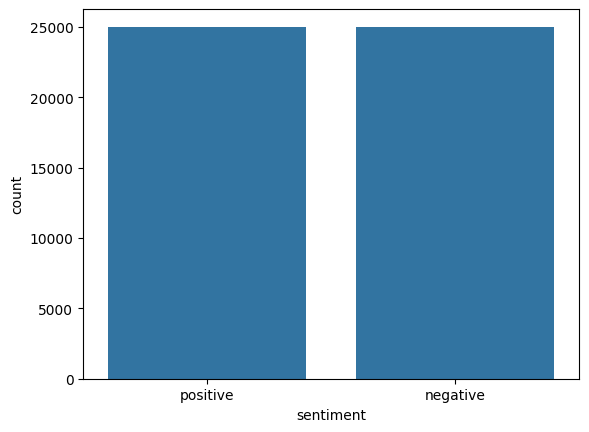

In [ ]:
# View the distribution of positive and negative sentiments in the dataset
sns.countplot(x='sentiment', data = movie_reviews)
plt.show()

In [ ]:
# removing the html strips
def strip_html(text):
    # BeautifulSoup is a useful library for extracting data from HTML and XML documents
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [ ]:
# removing punctuations
def remove_punctuations(text):

    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)

    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    # Removing multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text

In [ ]:
# Remove puntuations
movie_reviews['review'] = movie_reviews['review'].apply(remove_punctuations)
movie_reviews['review'] = movie_reviews['review'].str.lower()

In [ ]:
# setting english stopwords
stopword_list = nltk.corpus.stopwords.words('english')
print(stopword_list)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [ ]:
# Exclude 'not' and its other forms from the stopwords list

updated_stopword_list = []

for word in stopword_list:
    if word=='not' or word.endswith("n't"):
        pass
    else:
        updated_stopword_list.append(word)

print(updated_stopword_list)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', 'd', 'did', 'didn', 'do', 'does', 'doesn', 'doing', 'don', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', 'has', 'hasn', 'have', 'haven', 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', 'more', 'most', 'mustn', 'my', 'myself', 'needn', 'no', 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', 'she', "she'd", "she'll", "she's", 'should', 'shouldn', "should've", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs'

In [ ]:
# removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    # splitting strings into tokens (list of words)
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        # filtering out the stop words
        filtered_tokens = [token for token in tokens if token not in updated_stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in updated_stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [ ]:
# Apply function on review column
movie_reviews['review'] = movie_reviews['review'].apply(remove_stopwords)

In [ ]:
movie_reviews.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive


In [ ]:
# Convert sentiment labels to integers

movie_reviews['sentiment'] = movie_reviews['sentiment'].apply(lambda x: 1 if x=="positive" else 0)

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(movie_reviews['review'].values, movie_reviews['sentiment'].values,
                                                    test_size=0.20,
                                                    random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(40000, 10000, 40000, 10000)

In [ ]:
# Tokenizer class from the keras.preprocessing.text module creates a word-to-index dictionary
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Find the vocabulary size and perform padding on both train and test set
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train_pad = pad_sequences(X_train_tok, padding='post', maxlen=maxlen, truncating='post')
X_test_pad = pad_sequences(X_test_tok, padding='post', maxlen=maxlen, truncating='post')

In [ ]:
print ('number of unique words in the corpus:', vocab_size)

number of unique words in the corpus: 158927


In [ ]:
EMBEDDING_DIM = 64

print('Build model...')

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = EMBEDDING_DIM, input_length=maxlen))
model.add(LSTM(units=40,  dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# MISSING:
model.fit(X_train_pad, y_train, batch_size=128, epochs=5, validation_split=0.2)

print('Summary of the built model...')
print(model.summary())

Build model...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 76s 284ms/step - accuracy: 0.5438 - loss: 0.6794 - val_accuracy: 0.7475 - val_loss: 0.5644
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 71s 283ms/step - accuracy: 0.7082 - loss: 0.5964 - val_accuracy: 0.6930 - val_loss: 0.5970
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 282ms/step - accuracy: 0.7146 - loss: 0.5846 - val_accuracy: 0.7089 - val_loss: 0.5688
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 284ms/step - accuracy: 0.7523 - loss: 0.5241 - val_accuracy: 0.8183 - val_loss: 0.4384
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 290ms/step - accuracy: 0.8348 - loss: 0.4091 - val_accuracy: 0.8357 - val_loss: 0.3897
Summary of the built model...


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (128, 100, 64)         │    10,171,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (128, 40)              │        16,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (128, 1)               │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,564,509 (116.59 MB)

 Trainable params: 10,188,169 (38.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,376,340 (77.73 MB)

None


In [ ]:
print('Testing...')
y_test = np.array(y_test)
score, acc = model.evaluate(X_test_pad, y_test, batch_size=128)

print('Test score:', score)
print('Test accuracy:', acc)

print("Accuracy: {0:.2%}".format(acc))

Testing...
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8358 - loss: 0.3887
Test score: 0.39516595005989075
Test accuracy: 0.8323000073432922
Accuracy: 83.23%


In [ ]:
#Let us test some  samples
test_sample_1 = "This movie is fantastic! I really like it because it is so good!"
test_sample_2 = "Good movie!"
test_sample_3 = "Maybe I like this movie."
test_sample_4 = "Not to my taste, will skip and watch another movie"
test_sample_5 = "if you like action, then this movie might be good for you."
test_sample_6 = "Bad movie!"
test_sample_7 = "Not a good movie!"
test_sample_8 = "This movie really sucks! Can I get my money back please?"
test_samples = [test_sample_1, test_sample_2, test_sample_3, test_sample_4, test_sample_5, test_sample_6, test_sample_7, test_sample_8]

test_samples_tokens = tokenizer.texts_to_sequences(test_samples)
test_samples_tokens_pad = pad_sequences(test_samples_tokens, maxlen=maxlen)

# predict
pred = model.predict(x=test_samples_tokens_pad)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


array([[0.8522112 ],
       [0.8168782 ],
       [0.77381116],
       [0.63179106],
       [0.8559467 ],
       [0.62895125],
       [0.8010623 ],
       [0.52125484]], dtype=float32)